# COVID-19 Classification from Chest X-Ray Images
The COVID-19 pandemic highlighted the urgent need for fast, accessible diagnostic tools. While RT-PCR remains the gold standard, it has limitations in cost, accessibility, and turnaround time. This project addresses those challenges by developing a Convolutional Neural Network (CNN) for automated classification of chest X-ray (CXR) images. The model distinguishes between COVID-19, pneumonia, and healthy lungs, providing a scalable, low-cost, and rapid decision support tool for clinicians, especially in resource-limited settings.

## Essential Library Imports and Setup

Every great project starts with the right tools. In this section, we’ll bring in the necessary Python libraries to handle data, build and train the model, visualize the results, and apply image augmentations to improve generalization.

The libraries we’ll use include:
- **TensorFlow / Keras** for constructing and training the deep learning model.
- **OpenCV (cv2)** for image reading and preprocessing.
- **Matplotlib and Seaborn** for visualizing datasets and results.
- **Albumentations** for image augmentation techniques to increase model robustness.
- **Pandas and NumPy** for efficient data handling and manipulation.

Each of these libraries serves a specialized purpose in the workflow, together enabling us to go from raw images to a fully trained classifier.

In [2]:
# Essential Libraries for Image Classification
import keras
import cv2, os, gc, glob  # For image handling and file operations
import numpy as np  # For numerical operations
import pandas as pd  # For handling dataframes
import matplotlib # For basic plotting
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns  # For enhanced visualizations
import matplotlib.cm as cm  # For color mapping
import matplotlib.image as mpimg  # For image loading
import albumentations as A  # For image augmentations

# TensorFlow/Keras for building and training the model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Input

# Keras Model utilities for optimization and performance
from keras.optimizers import Adam as adam
from keras.utils import to_categorical

# Sklearn for data splitting and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Utility for progress tracking
from tqdm import tqdm

# For cycling through colors in the plot
from itertools import cycle

## Dataset Acquisition and Preprocessing
Our dataset comes from a Kaggle repository of chest X-ray images (https://www.kaggle.com/datasets/alsaniipe/chest-x-ray-image), containing labeled cases of COVID-19, Pneumonia, and Normal lungs.
The first step is to systematically collect the file paths of all images in the dataset folders so we can later read and process them.
At this stage, we are not yet reading the images, just making an inventory of where everything is located.

In [3]:
# Load the dataset
imagePaths = []
for dirname, _, filenames in os.walk('../Data/'):
    for filename in filenames:
        if (filename[-3:] == 'png' or 'jpg'):
            imagePaths.append(os.path.join(dirname, filename))

Now that we have the file paths, it’s time to start reading the images themselves and assigning the correct labels to each one.
This step is like unpacking boxes from storage: each file path points to an image, and we’ll pair it with its category - COVID-19, Pneumonia, or Normal.
We’ll also resize all images to the same dimensions (100×100 pixels) so that the deep learning model receives consistent input. Without this, the training process would be inefficient and prone to errors.

In [4]:
# Initialize lists to hold data and target labels
Data = []
Target = []
resize = 100

categories = {'PNEUMONIA': 'Pneumonia', 'NORMAL': 'Normal', 'COVID19': 'COVID19'}

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2].split("/")[-1]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) / 255.0
    image = image.astype(np.float32)

    Data.append(image)
    Target.append(categories[label])

100%|██████████| 6432/6432 [05:11<00:00, 20.62it/s] 


## Convert the list to DataFrame & Plot the count

To better understand our dataset composition, we convert our labels into a Pandas DataFrame.
This makes it much easier to perform statistical checks and visualize the distribution of cases.
While the model itself will eventually work with numeric arrays, as humans, we benefit from having the data in a readable, tabular format for exploration.
With the labels organized, let’s take a closer look at how many examples we have for each class.
A countplot will quickly reveal whether our dataset is balanced or skewed toward certain categories.

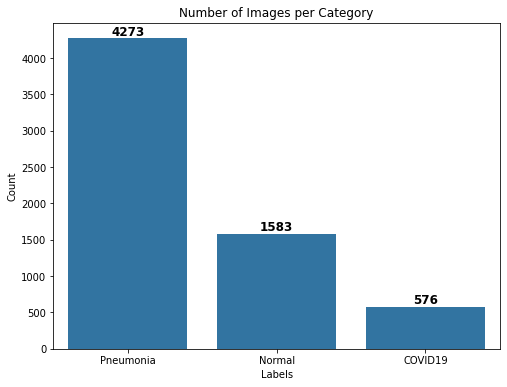

Number of Images for each Category:
COVID: 576 
NORMAL: 1583 
PNEUMONIA: 4273


In [5]:
# Convert the list to DataFrame
df = pd.DataFrame(Target, columns=['Labels'])

# Create countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Labels', order=df['Labels'].value_counts().index)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Number of Images per Category")

# Add count labels
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(str(count), (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.savefig("../images/count.png")
plt.show()

print("Number of Images for each Category:"
      '\nCOVID:',Target.count('COVID19'),
      '\nNORMAL:',Target.count('Normal'),
      '\nPNEUMONIA:',Target.count('Pneumonia'))

This dataset contains a total of 6432 chest X-ray images, categorized into three classes: NORMAL, PNEUMONIA, and COVID19.
The count of individual images of each category is shown in the plot above. The dataset consists of 576 Covid X-Rays, 1583 Normal X-Rays and 4273 Pneumonia X-Rays.

From the chart, we can immediately see that the dataset is not perfectly balanced.
Here, pneumonia has significantly more samples than the others.
This matters because deep learning models trained on imbalanced data tend to be overconfident in predicting the majority class.
Later, we might need to address this issue through data augmentation or sampling techniques.

## Visualizing

Numbers and charts are informative, but seeing the actual images gives us a much deeper intuition.
By displaying a few sample X-rays from each class, we can get a sense of the visual differences the model will need to learn.
COVID-19 cases might show distinctive lung opacities, while Pneumonia images could display more localized patterns. Normal lungs should appear relatively clear.

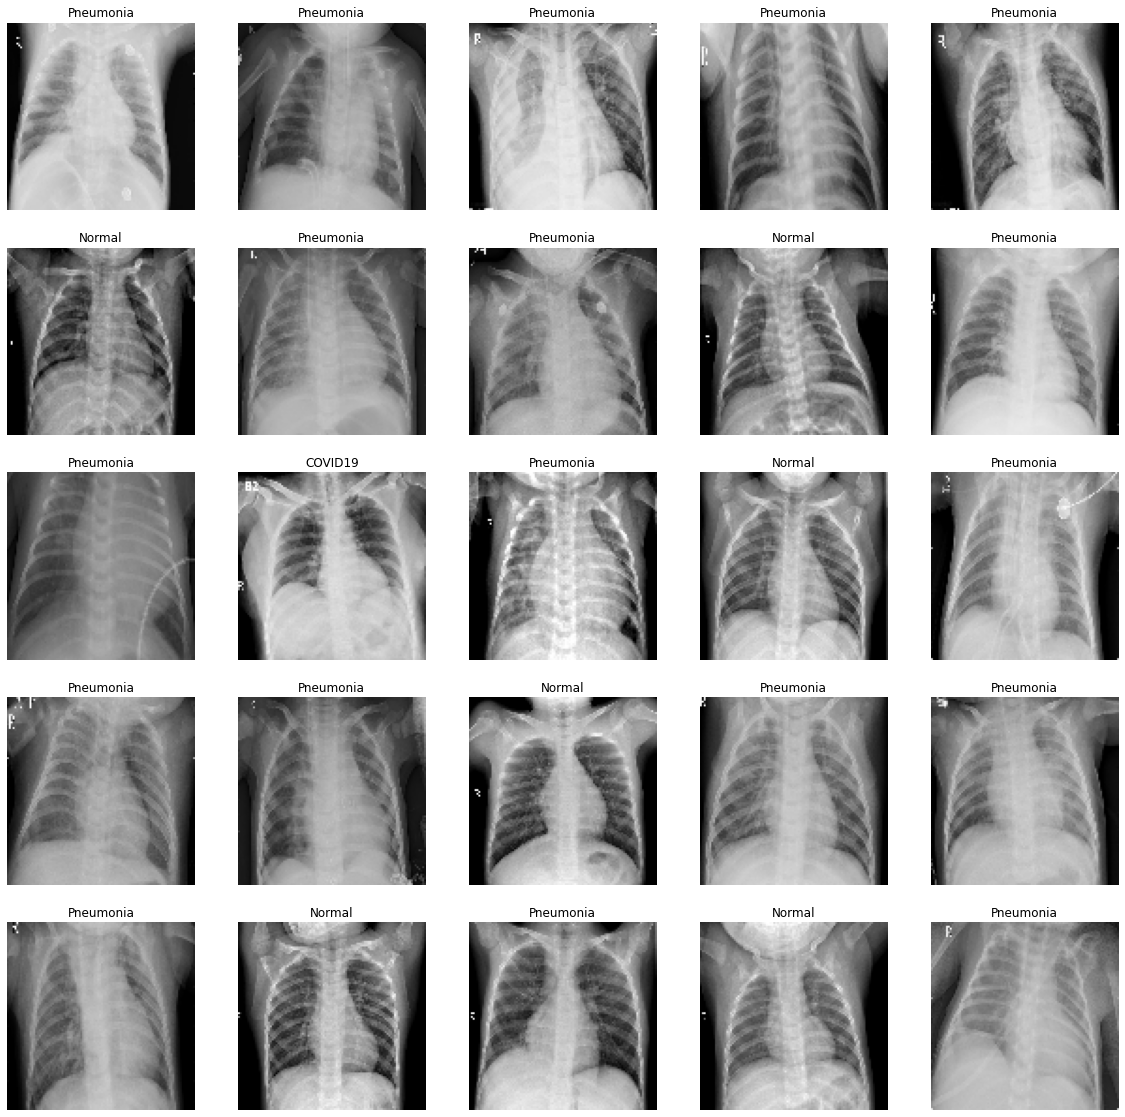

In [6]:
# Displaying some images from the dataset
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

Even at this stage, you can start spotting patterns, subtle or obvious, that distinguish one class from another.
Of course, the model will detect patterns far beyond the capacity of the human eye, but this preview helps us appreciate the complexity of the task.

## Image Data Augmentation

Data augmentation is used to increase the diversity of the training dataset. This helps to reduce overfitting and improves the model's generalization capabilities on unseen data. The `albumentations` library is used to perform various transformations, such as rotation, flipping, and blurring. A pipeline of augmentations is defined to apply a series of random transformations to the images.

Before we hand the images to the model, we normalize their pixel values.
This means scaling the raw pixel intensities from the range 0–255 down to 0–1.
Normalization makes the optimization process more stable and can speed up training.
It’s a small step, but in deep learning, such preprocessing details often make the difference between a struggling model and a strong one.

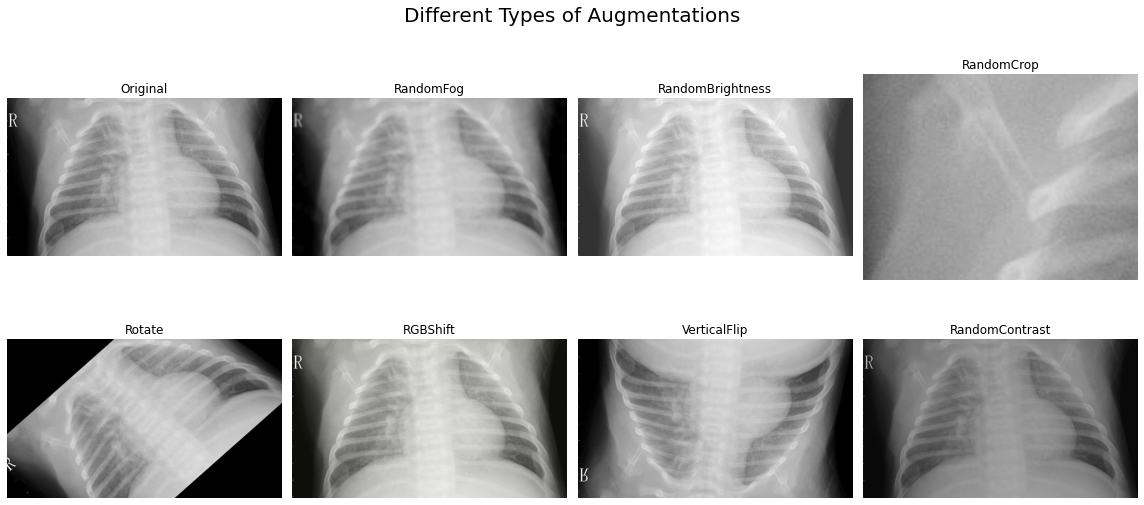

In [7]:
# Function to plot multiple images in a grid
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

# Load the image
chosen_image = cv2.imread(imagePath)

# Use Albumentations transforms
albumentation_list = [
    A.RandomFog(p=1),
    A.RandomBrightnessContrast(brightness_limit=0.2, p=1),  
    A.RandomCrop(height=150, width=200, p=1),
    A.Rotate(limit=90, p=1),
    A.RGBShift(p=1),
    A.VerticalFlip(p=1),
    A.RandomBrightnessContrast(contrast_limit=0.5, p=1)  
]

# Apply transforms
img_matrix_list = [chosen_image]
for aug_type in albumentation_list:
    img = aug_type(image=chosen_image)['image']
    img_matrix_list.append(img)

# Titles
titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", 
               "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

# Plot function 
def plot_multiple_img(img_matrix_list, title_list, ncols=4, main_title=""):
    n_images = len(img_matrix_list)
    nrows = (n_images + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()
    for i in range(len(img_matrix_list)):
        img = img_matrix_list[i]
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(title_list[i])
        axs[i].axis('off')
    for j in range(len(img_matrix_list), len(axs)):
        axs[j].axis('off')
    plt.suptitle(main_title, fontsize=20)
    plt.tight_layout()
    plt.savefig("../images/augmentation.png")
    plt.show()

# Plot
plot_multiple_img(img_matrix_list, titles_list, ncols=4, main_title="Different Types of Augmentations")

Trying different augmentations on our data produces the results above. We can see that augmentations here can cause loss of information and won't really help in improving the model performance. 

## Encoding the Labels for Classification

This step encodes the target labels (COVID-19, Normal, Pneumonia) into numerical format and then converts them into categorical form for model training.

In [8]:
# Encode the labels
le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['COVID19' 'Normal' 'Pneumonia']
[1. 0. 0.]


## Dividing Data into Training, Validation, and Test Sets

With the images processed and normalized, the next step is to split them into training and testing sets.
The training set will be used to teach the model, while the test set will serve as unseen data to evaluate its performance.
This separation is essential, without it we would have no reliable way to know if our model has genuinely learned to generalize or if it’s simply memorizing the training examples (overfitting).

To partition the data, we utilize the `train_test_split` function from scikit-learn, creating separate training, validation, and testing subsets.

In [9]:
# First split into train and test
x_train, x_test, y_train, y_test = train_test_split(Data, labels, test_size=0.20, stratify=labels, random_state=123)

# Then split train into train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

# Convert to arrays with smaller dtype to save memory
trainX = np.array(x_train, dtype=np.float32)
testX = np.array(x_test, dtype=np.float32)
valX = np.array(x_val, dtype=np.float32)

trainY = np.array(y_train)
testY = np.array(y_test)
valY = np.array(y_val)

# Print shapes
print("Train X:", trainX.shape)
print("Validation X:", valX.shape)
print("Test X:", testX.shape)
print("Train Y:", trainY.shape)
print("Validation Y:", valY.shape)
print("Test Y:", testY.shape)


Train X: (4630, 100, 100, 3)
Validation X: (515, 100, 100, 3)
Test X: (1287, 100, 100, 3)
Train Y: (4630, 3)
Validation Y: (515, 3)
Test Y: (1287, 3)


At the end of this step, we have two clean partitions of data: one for learning, one for honest evaluation.
The ratio between them is chosen carefully to ensure enough data for training without starving the test set of variety.

## Building the CNN Model

At this stage, we define the CNN architecture responsible for categorizing X-ray images into NORMAL, PNEUMONIA, or COVID19.

Now comes the heart of the project, defining the deep learning architecture.
We are building a Convolutional Neural Network (CNN) because it is particularly well-suited for image classification tasks.
CNNs excel at detecting spatial hierarchies in images: they start by finding small patterns like edges and gradients, and gradually assemble them into complex features like shapes and textures.
Here, we design a layered architecture that:

1. Extracts features from X-rays using convolutional and pooling layers.
2. Passes these features through fully connected layers to combine and interpret them.
3. Outputs the predicted probability for each class: COVID-19, Pneumonia, or Normal.

In [10]:
# Define the CNN model
model = Sequential()

model.add(Input(shape=(100, 100, 3)))  

# CNN layers
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))

model.add(Dropout(0.25))

# Fully connected
model.add(Flatten())
model.add(Dense(64, activation="relu")) # Fully connected layer with 64 neurons
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))  # Output layer for 3 classes

In order to automatically identify COVID-19 from chest X-ray pictures, we create a deep learning model.  Three convolutional layers with the input shape (100, 100, 3) make up the architecture, which introduces non-linearity using the Rectified Linear Unit (ReLU) activation function.  32 filters are applied by the first convolutional layer in order to extract features from the input image.  The model uses L2 regularization and dropout to improve generalization and reduce overfitting.  Effective multi-class classification is made possible by the last dense layer, which outputs class probabilities using a softmax activation function.

## Compiling and Training the CNN Model

With accuracy serving as the evaluation metric and categorical cross-entropy as the loss function, the model is assembled using the Adam optimizer.  The amount of trainable parameters at each level and the form of each layer are revealed in the model summary.  The model is set up to train 3,370,307 parameters in total.

Once the architecture is in place, we need to compile the model.
Compiling defines:
* Optimizer: Determines how the model’s weights are updated during training. (Here, we use Adam for its adaptive learning rate.)
* Loss function: Measures how wrong the model’s predictions are (categorical crossentropy is suitable for multi-class classification).
* Metrics: The statistics we track to evaluate performance (accuracy is our primary metric here).
This step is like giving our model a set of learning rules before we send it to school.

In [11]:
# Compile the model
model.compile(optimizer = adam(),
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,307 (12.86 MB)

 Trainable params: 3,370,307 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

None


In Keras, None in the model summary indicates the batch size, which is flexible and not fixed, allowing the model to process any batch size during training or inference.

## Train the model
With everything in place, it’s time to let the model learn.
We feed the training images through the network in multiple epochs, each epoch means the model sees every training image once and updates its internal parameters to improve accuracy.
The validation data allows us to monitor whether the model’s learning is translating well to unseen examples.
During training, we expect the loss to decrease and accuracy to improve. If accuracy on the validation set stalls or drops while training accuracy keeps climbing, it could be a sign of overfitting.

In [12]:
# Train the model
gc.collect()  # Clear memory before training
epochs = 50
cnn = model.fit(trainX, trainY, validation_data = (valX, valY), epochs=epochs,
                      batch_size=32,  verbose = 1)

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 283ms/step - accuracy: 0.7524 - loss: 0.6207 - val_accuracy: 0.9301 - val_loss: 0.2482
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 34s 233ms/step - accuracy: 0.9235 - loss: 0.2574 - val_accuracy: 0.9087 - val_loss: 0.2516
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 218ms/step - accuracy: 0.9385 - loss: 0.2153 - val_accuracy: 0.9340 - val_loss: 0.2265
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 31s 214ms/step - accuracy: 0.9476 - loss: 0.1774 - val_accuracy: 0.9340 - val_loss: 0.1938
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.9503 - loss: 0.1712 - val_accuracy: 0.9379 - val_loss: 0.1937
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 31s 213ms/step - accuracy: 0.9623 - loss: 0.1349 - val_accuracy: 0.9398 - val_loss: 0.1840
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 31s 213ms/step - accuracy: 0.9677 - loss: 0.1218 - val_accuracy: 0.9262 - val_loss: 0.2024
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.9666 - loss: 0

The model is trained for 50 epochs with a batch size of 32 using the training and validation sets.

By the end of training, the model has transformed from a random collection of weights into a specialized pattern detector for chest X-rays.
The next step is to see how well it performs on the test data, the real measure of its ability.

## Model Evaluation and Results

After training, the crucial question is: Can the model perform well on data it has never seen before?
Here, we feed the test set into the trained network and measure its performance in terms of accuracy and loss.
This step is a true test of generalization, a model that only performs well on the training set but fails here is not useful in the real world.

In multi-class classification, we assess model performance by examining prediction accuracy on unseen data.
These metrics can help us quantify how well our CNN models fit the data and generalize to new data.

In [13]:
# Evaluate the model on the test set
modelLoss, modelAccuracy = model.evaluate(testX, testY, verbose=0)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))

class_names = ['COVID19','NORMAL','PNEUMONIA']

y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[1])])

Test Loss is 0.2959787845611572
Test Accuracy is 0.9463869333267212
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
COVID19


The model achieved an accuracy of 95% on the test dataset.

The accuracy on the test set gives us a first indicator of success.
However, accuracy alone may not tell the full story, especially if our dataset is imbalanced. That’s why we will complement this with more detailed metrics and visual diagnostics.

## Plotting Multi-Class ROC Curves and AUC Scores

This code computes and plots the ROC curves for each class (COVID-19, Normal, Pneumonia) along with the AUC (Area Under the Curve) scores.

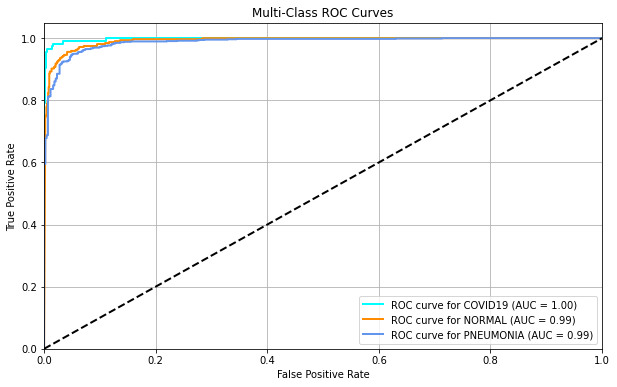

In [14]:
# Number of classes
n_classes = len(class_names)

# Setup plot dimensions
plt.figure(figsize=(10, 6))

# Colors for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

# Compute and plot ROC curve for each class
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(testY[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve for {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc))

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot appearance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)

# Save and display plot
plt.savefig("../images/roc_curves.png")
plt.show()

## Interpretation of ROC Curves

The ROC curves above illustrate the model's performance across three classes: COVID-19, Normal, and Pneumonia.

- The **COVID-19** class shows a perfect ROC curve with an AUC of **1.00**, indicating flawless classification.
- The **Normal** and **Pneumonia** classes both have high AUC values of **0.99**, showing excellent performance in differentiating these classes.
- The **dashed diagonal line** represents random chance (AUC = 0.5), and the closer the ROC curves are to the top-left corner, the better the model's performance.

Overall, the model demonstrates strong classification capabilities with minimal false positives, indicating reliable diagnostic accuracy for all three classes.

## Detailed Classification Metrics

To measure how well the model performs per class, we generate a classification report.
We calculate the classification report for each train, validation and test sets to get an idea of how well the model has performed in each set.

To go beyond accuracy, we generate predictions for each image in the test set and compare them to the true labels.
This allows us to produce a classification report, which includes:
* Precision: How many of the model’s positive predictions were correct.
* Recall (Sensitivity): How many actual positive cases the model correctly detected.
* F1-score: A balanced measure that considers both precision and recall.
In medical diagnostics, recall is often critical because missing a true case of COVID-19 or pneumonia can have serious consequences.

In [15]:
# Predict on the training set and print classification report
batch_size=32

predIdxs = model.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step
              precision    recall  f1-score   support

     COVID19    1.00000   1.00000   1.00000       411
      Normal    0.99652   1.00000   0.99826      1145
   Pneumonia    1.00000   0.99870   0.99935      3074

    accuracy                        0.99914      4630
   macro avg    0.99884   0.99957   0.99920      4630
weighted avg    0.99914   0.99914   0.99914      4630



In [16]:
# Predict on the validation set and print classification report
predIdxs = model.predict (valX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(valY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
              precision    recall  f1-score   support

     COVID19    0.97917   0.94000   0.95918        50
      Normal    0.84444   0.94215   0.89062       121
   Pneumonia    0.96988   0.93605   0.95266       344

    accuracy                        0.93786       515
   macro avg    0.93116   0.93940   0.93416       515
weighted avg    0.94131   0.93786   0.93872       515



In [17]:
# Predict on the test set and print classification report
predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
              precision    recall  f1-score   support

     COVID19    0.97248   0.92174   0.94643       115
      Normal    0.88235   0.94637   0.91324       317
   Pneumonia    0.96897   0.94971   0.95924       855

    accuracy                        0.94639      1287
   macro avg    0.94127   0.93927   0.93964      1287
weighted avg    0.94795   0.94639   0.94677      1287



The **F1 score** serves as the main focus, as it balances both precision and recall, offering a more comprehensive view of model performance. Given that **recall** is critical in medical diagnostics (e.g., identifying true cases of COVID-19 or pneumonia), the F1 score is a reliable indicator of the model’s accuracy.

In terms of performance:
- **Test set accuracy**: ~95%
- **Validation set accuracy**: ~94%

The **support values** reflect the number of samples used for evaluation in each class during training and testing, ensuring the model's robustness across various data points.

## Confusion Matrix Analysis

A confusion matrix offers an intuitive, visual representation of the model’s performance.
Each row represents the true class, and each column represents the predicted class. The diagonal cells are correct predictions; off-diagonal cells represent mistakes.
This tool lets us pinpoint specific types of errors. For example, whether the model confuses COVID-19 with pneumonia more than with normal lungs.

By contrasting accurate and inaccurate predictions across all three categories, the confusion matrix is used to evaluate the model's performance.  Notably, COVID-19 and pneumonia have similar sensitivity (recall), suggesting that both diseases can be detected with high accuracy.  In light of the task's criticality, special focus is placed on reducing false negatives, or instances in which COVID-19 is mistakenly identified as non-COVID.  The fact that the model only produces two false negatives throughout the whole dataset is encouraging and could be explained by the radiographic features that overlap between the classes.

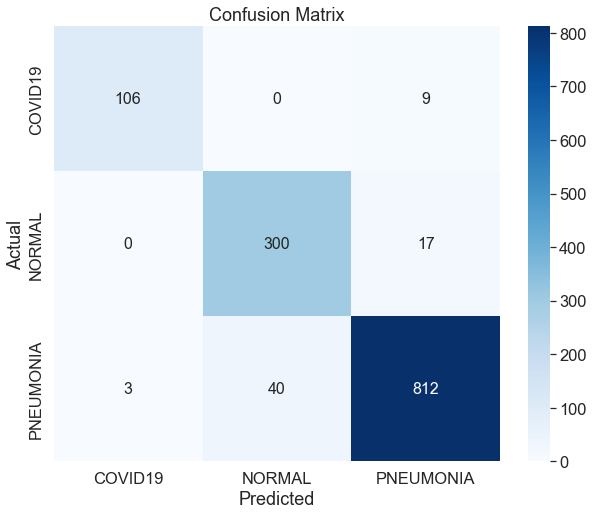

In [18]:
# Plot confusion matrix for the test set
plt.figure(figsize=(10, 8))
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x, index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='Blues')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.savefig("../images/confusionmatrix.png")
plt.show()

By studying the matrix, we can identify patterns in misclassification.
In a medical context, this helps prioritize improvements where they matter most. For instance, ensuring COVID-19 is rarely misclassified as normal.

## Metrics for Each Class

This code calculates essential classification metrics (True Positives, True Negatives, False Positives, and False Negatives) for each class in the confusion matrix. These metrics help evaluate the model's performance per class by analyzing the number of correctly and incorrectly classified instances.

In [19]:
# Calculate metrics for each class
# Loop through each class to calculate metrics
for i, class_name in enumerate(class_names):
    # True Positives (TP): The diagonal element of the class
    tp = x[i, i]
    
    # False Positives (FP): The sum of the column for that class, excluding the diagonal element
    fp = np.sum(x[:, i]) - tp
    
    # False Negatives (FN): The sum of the row for that class, excluding the diagonal element
    fn = np.sum(x[i, :]) - tp
    
    # True Negatives (TN): The sum of all other elements not in that class's row or column
    tn = np.sum(x) - (tp + fp + fn)
    
    print(f"Metrics for class: {class_name}")
    print(f"  - True Positives (TP): {tp}")
    print(f"  - True Negatives (TN): {tn}")
    print(f"  - False Positives (FP): {fp}")
    print(f"  - False Negatives (FN): {fn}")
    print("-" * 30)

Metrics for class: COVID19
  - True Positives (TP): 106
  - True Negatives (TN): 1169
  - False Positives (FP): 3
  - False Negatives (FN): 9
------------------------------
Metrics for class: NORMAL
  - True Positives (TP): 300
  - True Negatives (TN): 930
  - False Positives (FP): 40
  - False Negatives (FN): 17
------------------------------
Metrics for class: PNEUMONIA
  - True Positives (TP): 812
  - True Negatives (TN): 406
  - False Positives (FP): 26
  - False Negatives (FN): 43
------------------------------


## Individual Confusion Matrices for Each Class (One-vs-Rest)

This code generates individual confusion matrices for each class in a one-vs-rest manner. It calculates True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for each class, visualizing them in a heatmap to assess how well the model distinguishes each class from the others.

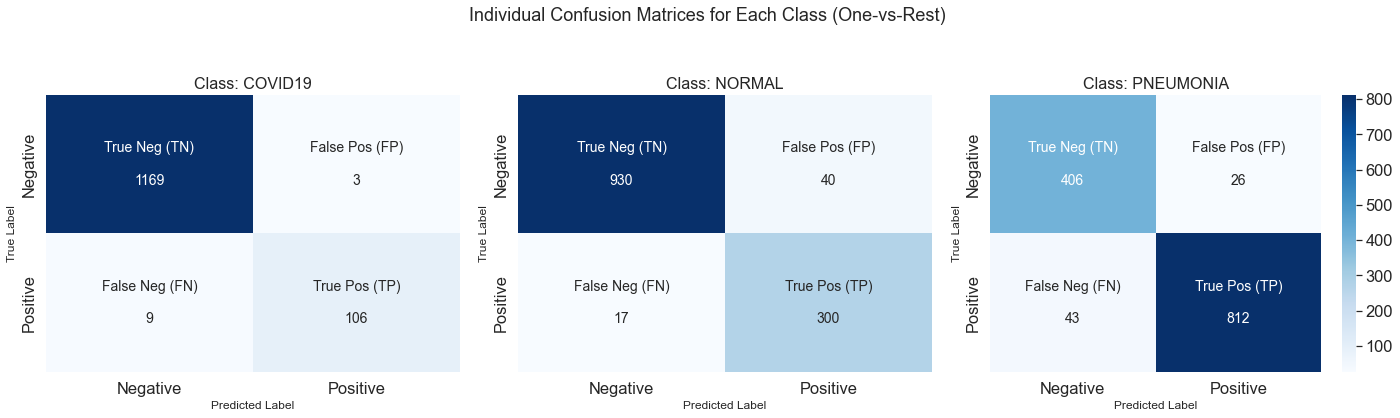

In [20]:
# Calculate the 3x3 confusion matrix
cm = confusion_matrix(testY.argmax(axis=1), y_pred.argmax(axis=1))

# Create a figure with 3 subplots (one for each class)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Individual Confusion Matrices for Each Class (One-vs-Rest)', fontsize=18)

# Define the labels for the 2x2 matrix cells
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

# Loop through each class to create its 2x2 matrix
for i, class_name in enumerate(class_names):
    # Calculate TP, TN, FP, FN for the current class
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    # Create the 2x2 matrix
    binary_cm = np.array([[tn, fp], [fn, tp]])
    
    # Create labels with values for the heatmap
    labels = [f"{name}\n\n{value}" for name, value in zip(group_names, binary_cm.flatten())]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot the heatmap
    sns.heatmap(binary_cm, ax=axes[i], annot=labels, fmt='', cmap='Blues', cbar= i==2, annot_kws={"size": 14})
    axes[i].set_title(f'Class: {class_name}', fontsize=16)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)
    axes[i].set_xticklabels(['Negative', 'Positive'])
    axes[i].set_yticklabels(['Negative', 'Positive'])
    
# Adjust layout 
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig("../images/individual_confusion_matrices.png", dpi=300) 
plt.show()

## Model Saving

We save the trained model as a .keras file. This includes the weights of each layer which can be recalled without using the time and resources in training the model again.

In [21]:
# Save the model 
if not os.path.exists("../model"):
    os.makedirs("../model")
model.save("../model/xray_cnn_model.keras")

In [22]:
# Load the model
model = tf.keras.models.load_model("../model/xray_cnn_model.keras", compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Check the model's history keys
print(cnn.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## Accuracy and Loss Graphs

In order to comprehend model behavior, learning curves are essential.  One may evaluate the model's learning efficiency, identify overfitting or underfitting, and identify the best time to halt training in order to prevent performance degradation on unseen data by examining both loss and accuracy trends.  It is crucial to keep an eye on these curves in order to assess model performance and make well-informed modifications to training methods and hyperparameters.

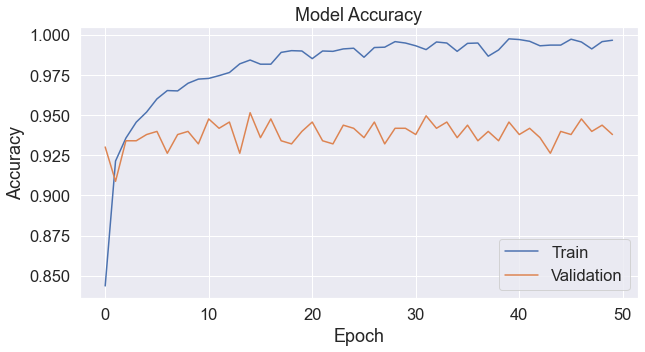

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.savefig("../images/accuracy.png")
plt.show()

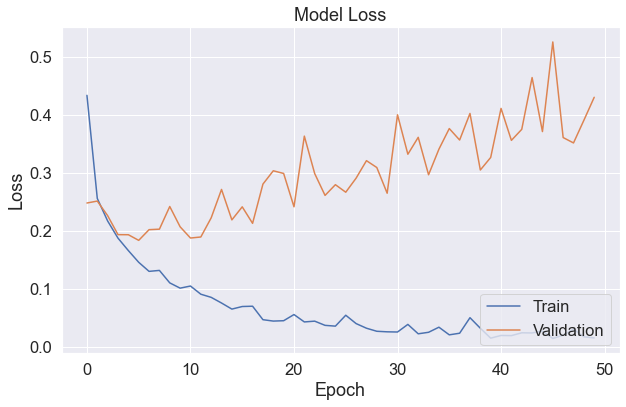

In [25]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.savefig("../images/loss.png")
plt.show()

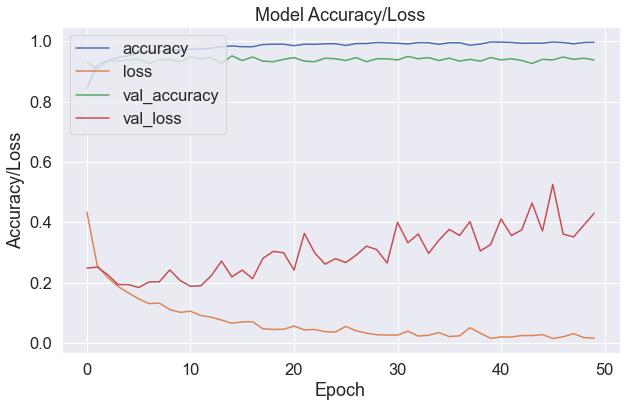

In [26]:
# Plot both accuracy and loss 
pd.DataFrame(cnn.history).plot(figsize=(10, 6))
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig("../images/accuracy_loss.png")
plt.show()

It’s also important to examine how the model learned over time.
We plot the training and validation accuracy and loss across epochs.
These curves reveal the learning dynamics:

If training and validation accuracy rise together, the model is learning well.
If training accuracy continues to improve while validation accuracy stalls or declines, overfitting may be occurring.

**The learning curves show that the model is able to generalize the data and there is no case of underfitting or overfitting.**

A smooth upward trend for both training and validation accuracy, along with a downward trend for loss, signals healthy learning. Sudden divergence, however, suggests adjustments may be needed in architecture, regularization, or data augmentation.

## Grad CAM Visualisation

The existence of scar tissue in chest X-ray pictures must be seen because of the seriousness of the problem.  Gradient-weighted Class Activation Mapping (Grad-CAM) creates a localized map that emphasizes important traits the model has detected by utilizing the gradients from a chosen convolutional layer.  The visualization shows the original chest X-ray pictures in the left column.  These are then used to generate a heatmap based on the traits the model identified.  In order to clearly identify regions where COVID-19-related scar tissue might be present, this heatmap is then superimposed on the original image.

In [27]:
# Display some images with their predicted labels through GradCAM
img_path = ["../Data/train/COVID19/COVID19(23).jpg",
           "../Data/train/COVID19/COVID19(25).jpg",
            "../Data/train/NORMAL/NORMAL(0).jpg",
            "../Data/train/NORMAL/NORMAL(1).jpg",
           "../Data/train/PNEUMONIA/PNEUMONIA(2).jpg",
           "../Data/train/PNEUMONIA/PNEUMONIA(5).jpg"]

In [28]:
# Function to display images with GradCAM heatmap
def get_img_array(img_path, size):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image at {img_path}")
    image = cv2.resize(img, (size, size))
    array = keras.preprocessing.image.img_to_array(image) 
    array = np.expand_dims(array, axis=0)
    return array

# Function to display images with GradCAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [29]:
# Load pretrained Xception model with top classification layer
model = keras.applications.Xception(weights="imagenet", include_top=True)

# input image size for Xception
img_size = (100, 100)

# Preprocessing & decoding for Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Find last Conv2D layer dynamically
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        print(f"Using last conv layer: {last_conv_layer_name}")
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in the model.")

Using last conv layer: conv2d_6


In [30]:
# Warm up the model once before the loop
img_array = preprocess_input(get_img_array(img_path[0], size=299))
_ = model.predict(img_array)

covid_noncovid_heatmap = []

for i in img_path:
    try:
        img_array = preprocess_input(get_img_array(i, size=299))
        preds = model.predict(img_array)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        covid_noncovid_heatmap.append(heatmap)
    except Exception as e:
        print(f"Failed on {i}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


In [31]:
# Function to save and display GradCAM heatmap on the original image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load image in RGB format
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # Apply the jet colormap
    jet = matplotlib.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose heatmap on image
    superimposed_img = jet_heatmap * alpha + img

    # Normalize image before saving
    superimposed_img -= superimposed_img.min()
    superimposed_img /= superimposed_img.max()
    superimposed_img *= 255
    superimposed_img = superimposed_img.astype(np.uint8)

    # Convert to BGR for OpenCV saving
    bgr_img = cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR)

    # Ensure output folder exists under 'images/gradcam_outputs'
    gradcam_output_folder = "../images/gradcam_outputs"
    os.makedirs(gradcam_output_folder, exist_ok=True)

    # Save image
    cv2.imwrite(f"{gradcam_output_folder}/cam_{i}.png", bgr_img)

    # Append for display
    images.append(superimposed_img)

images = []
for i in range(len(img_path)):
    out_path = f"../images/gradcam_outputs/cam_{i}.png"
    save_and_display_gradcam(img_path[i], covid_noncovid_heatmap[i], cam_path=out_path)


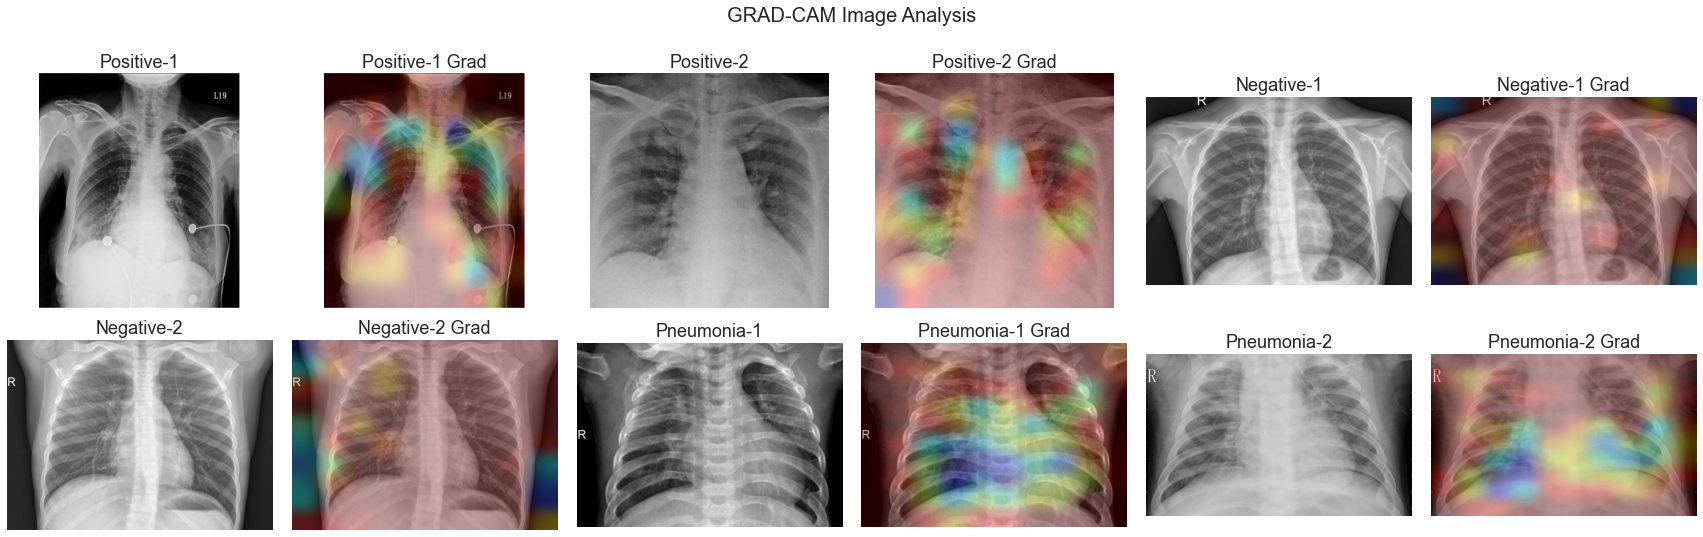

In [32]:
# Prepare titles for the images
titles_list = ["Positive-1",'Positive-1 Grad','Positive-2','Positive-2 Grad','Negative-1','Negative-1 Grad','Negative-2','Negative-2 Grad',
              'Pneumonia-1','Pneumonia-1 Grad','Pneumonia-2','Pneumonia-2 Grad']

original_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in img_path]

# Combine original + Grad-CAM images
combined_images = []
for orig, grad in zip(original_images, images):
    combined_images.append(orig)
    combined_images.append(grad)

plot_multiple_img(combined_images, titles_list, ncols=6, main_title="GRAD-CAM Image Analysis")


The high-intensity visuals (blue and green) reflects the area of interest to our model
at the time of prediction.

## Conclusion
In this project, we developed a convolutional neural network capable of classifying chest X-ray images into COVID-19, Pneumonia, and Normal cases.
Starting from raw image paths, we processed and normalized the data, designed and trained the model, and evaluated it using accuracy, precision, recall, and a confusion matrix.
The results show that deep learning holds strong potential for assisting medical professionals, especially in settings where rapid diagnosis is crucial.
However, the limitations including dataset size and class imbalance highlight the need for further research, possibly involving larger, more diverse datasets and techniques to mitigate bias.

This work is not intended to replace human expertise but to complement it, providing a fast, scalable diagnostic tool that can support clinical decision-making.